# Script based external simulators

In this notebook, we demonstrate the usage of the script based external simulators, summary statistics, and distance functions features.

These allow to use near-arbitrary programing languages and output for pyABC. The main concept is that all communication happens via the file system. This comes at the cost of a considerable overhead, making this feature not optimal for models with a low simulation time. For more expensive models, the overhead should be negligible.

This notebooke replicates the using_R notebook, but circumvents usage of the rpy2 package. Note the considerably longer runtime though.

In [1]:
import pyabc
import pyabc.external

/home/yannik/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Here, we define model, summary statistics and distance. Note that if possible, alternatively FileIdSumStat can be used to read in the summary statistics directly to python and then use a python based distance function.

In [2]:
model = pyabc.external.ExternalModel(script_name="Rscript", model_file="rmodel/model.r")
sumstat = pyabc.external.ExternalSumStat(script_name="Rscript", sumstat_file="rmodel/sumstat.r")
distance = pyabc.external.ExternalDistance(script_name="Rscript", distance_file="rmodel/distance.r")

dummy_sumstat = {'file': "", 'returncode': 0}  # can also use a real file here

Example of how the functions can be called:

In [3]:
pars = {'meanX': 3, 'meanY': 4}
mf = model(pars)
print(mf)
sf = sumstat(mf)
print(sf)
distance(sf, dummy_sumstat)

/tmp/modelsim_u9k00qqu
{'file': '/tmp/sumstat_21de8f23', 'returncode': 0}


4.595061

In [4]:
from pyabc import Distribution, RV, ABCSMC

prior = Distribution(meanX=RV("uniform", 0, 10),
                     meanY=RV("uniform", 0, 10))
abc = ABCSMC(model, prior, distance,
             summary_statistics=sumstat)

import os
from tempfile import gettempdir

db = "sqlite:///" + os.path.join(gettempdir(), "test.db")
abc.new(db, dummy_sumstat)

history = abc.run(minimum_epsilon=0.9, max_nr_populations=4)

INFO:History:Start <ABCSMC(id=6, start_time=2019-05-31 15:49:21.298688, end_time=None)>
INFO:Epsilon:initial epsilon is 4.4476144999999985
INFO:ABC:t:0 eps:4.4476144999999985
INFO:ABC:t:1 eps:2.885348
INFO:ABC:t:2 eps:1.735894242885352
INFO:ABC:t:3 eps:1.2668414883750014
INFO:History:Done <ABCSMC(id=6, start_time=2019-05-31 15:49:21.298688, end_time=2019-05-31 15:54:40.786203)>


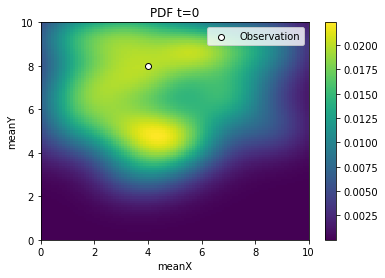

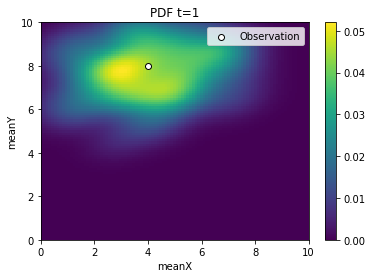

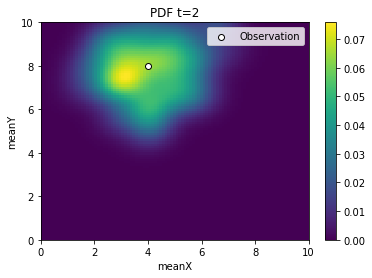

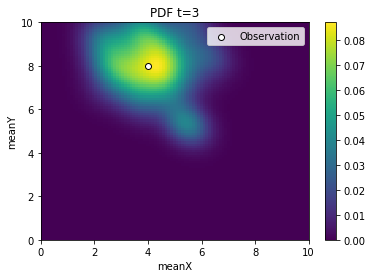

In [5]:
from pyabc.visualization import plot_kde_2d

for t in range(history.n_populations):
    df, w = abc.history.get_distribution(0, t)
    ax = plot_kde_2d(df, w, "meanX", "meanY",
                      xmin=0, xmax=10,
                      ymin=0, ymax=10,
                      numx=100, numy=100)
    ax.scatter([4], [8],
               edgecolor="black",
               facecolor="white",
               label="Observation");
    ax.legend();
    ax.set_title("PDF t={}".format(t))
    